# Identification of Weed using Convolution Neural Network

## Contents
    1. Introduction
    2. Preprocessing of Data
        2.1 Initialization
        2.2 Preprocessing step work flow
    3. CNN Model Creation and Training
        3.1 Dataset Preparation
        3.2 Model Creation
        3.3 Model Training
    4. Results 
        4.1 Training results
        4.2 Confusion Matrix
        4.3 f1 Scores
    5. Conclusion
    6. References
## 1. Introduction
Currently the world population is around 7.7 billions, and it is expected to increase to 9.8 billions by 2050. In such scenario, there will be huge a pressure to agricultural industries. Therefore, a lot of effort has been put in both industries and academia to increase the yield of crops. For instance, it has been reported in [1] the budget for research and development by in the fiscal year 2017-18 by is around 125 millions. 

There are numerous ways to increase the yield of crops. However, one of the major factors that affect the productivity  is weeds, which affect the crops growth in their early stages by absorbing nutrients in the soil. Therefore, their early identification and destruction is one of the ways to get rid of them. 

In the past few years, there has been a lot of interest in computer vision community to classify plant seedling so that such alien plants can be detected in their infant stage and destroyed. As a result, a dataset has been provided by some of the researchers from the Aarhus University [2]. The dataset is also available in the public domain such as kaggle.com. This notebook will demonstrate the development of a classification model using Convolution Neural Network (CNN) for the dataset. 

## 2. Preprocessing of Data
The dataset for the plant seedling classification has 12 classes, namely:
    1. Sugar beet
    2. Charlock
    3. Common Chickweed
    4. Maize
    5. Cleavers
    6. Scentless Mayweed 
    7. Black-grass
    8. Common wheat
    9. Small-flowered Cranesbill
    10.Shepherd’s Purse
    11.Loose Silky-bent
    12.Fat Hen
 Details on the database is available in [2].

### 2.1 Preprocessing 
In the dataset there is folder for each classes. In order to pave the way for the classification, the following steps will be applied for the preprocessing of data:
    1. creation of 'train' and 'valid' folders for the training and validation, respectively
    2. creation of folders inside the created folders for each classes.
In the training folder 225 will be randomly sampled from each class. Similarly, 25 images will be sampled in the "valid" folder.

### 2.2 Initialization

In [1]:
from numpy.random import seed
seed(101)
import random
from tensorflow import set_random_seed
set_random_seed(101)

import pandas as pd
import numpy as np
import cv2
import os
#import Pillow
from matplotlib import pyplot as plt 



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Creation of "train" and "valid" folders

In [2]:
listDir=os.listdir()
if 'train' not in listDir:
    os.mkdir('./train')
if 'valid' not in listDir:
    os.mkdir('./valid')

In [3]:
print(listDir)
removeItems = ['plant-seeding-script.ipynb','train', 'valid','Untitled.ipynb','.ipynb_checkpoints']

['Maize', 'Black-grass', '.ipynb_checkpoints', 'Common Chickweed', 'Small-flowered Cranesbill', 'Scentless Mayweed', 'plant-seeding-script.ipynb', 'Common wheat', 'Fat Hen', 'Cleavers', 'Sugar beet', 'train', 'Shepherd’s Purse', 'valid', 'Charlock', 'model1.h5', 'Loose Silky-bent']


In [4]:

listOfClasses =['Sugar beet', 'Charlock',
                'Common Chickweed', 'Maize',
                'Cleavers', 'Scentless Mayweed', 
                'Black-grass', 'Common wheat', 'Small-flowered Cranesbill', 
                'Shepherd’s Purse', 'Loose Silky-bent', 'Fat Hen']

#### Copying files of each classes into "train" and "test" folders
The file size is also changed to $290\times290$ while transfering files.

In [5]:
#no of files in each folder
imWidth =290
imHeight =290
def storeInPath(fileName,sourceFolder,destFolder):
    #input: fileName: name of the file
    #       sourceFolder: path to source file
    #        destFolder:path of the Folder where the file will be stored
    inputPath = sourceFolder +"/"+ fileName
    inputImg =cv2.imread(inputPath)
    
    resizedImg = cv2.resize(inputImg,(290, 290))
    temp=destFolder.split('/')
    imgFileName = destFolder+"/"+temp[-1]+"_"+fileName
    
    targetFileList=os.listdir(destFolder)
    #only store when the file is not present
    if imgFileName not in targetFileList:
        cv2.imwrite(imgFileName,resizedImg)
    
for item in listOfClasses:
    path= "./"+item
    fileList= os.listdir(path)
    addedList =[];
    
    
        
    trainFolder ="./train/"+item
    validFolder ="./valid/"+item
    lstTrain= os.listdir('./train')
    lstValid= os.listdir('./valid')
    if item not in lstTrain:
        os.mkdir(trainFolder)
    
    if item not in lstValid:
        os.mkdir(validFolder)
    #First check if the Destination folder is empty then only copy 
    if len(os.listdir(trainFolder))==0:
        for count in range(0,225):
            #random sample from the the list of files 
            sampleFile = random.sample(fileList,1)
            fileList.remove(sampleFile[0])
            storeInPath(sampleFile[0],path,trainFolder)
   
    if len(os.listdir(validFolder))==0:
        for count in range(0,25):
            sampleFile = random.sample(fileList,1)
            fileList.remove(sampleFile[0])
            storeInPath(sampleFile[0],path,validFolder)

Check the number of files in each class folder.

In [6]:
trainFolList = os.listdir('./train')
print("no of files in each folder inside train and valid folders")
for item in listOfClasses:
    trainFileList = os.listdir('./train/'+item)
        
    validFileList = os.listdir('./valid/'+item)
    print(item,'->',len(trainFileList),",",len(validFileList))



no of files in each folder inside train and valid folders
Sugar beet -> 225 , 25
Charlock -> 225 , 25
Common Chickweed -> 225 , 25
Maize -> 225 , 25
Cleavers -> 225 , 25
Scentless Mayweed -> 225 , 25
Black-grass -> 225 , 25
Common wheat -> 225 , 25
Small-flowered Cranesbill -> 225 , 25
Shepherd’s Purse -> 225 , 25
Loose Silky-bent -> 225 , 25
Fat Hen -> 225 , 25


Print the files from each folder.

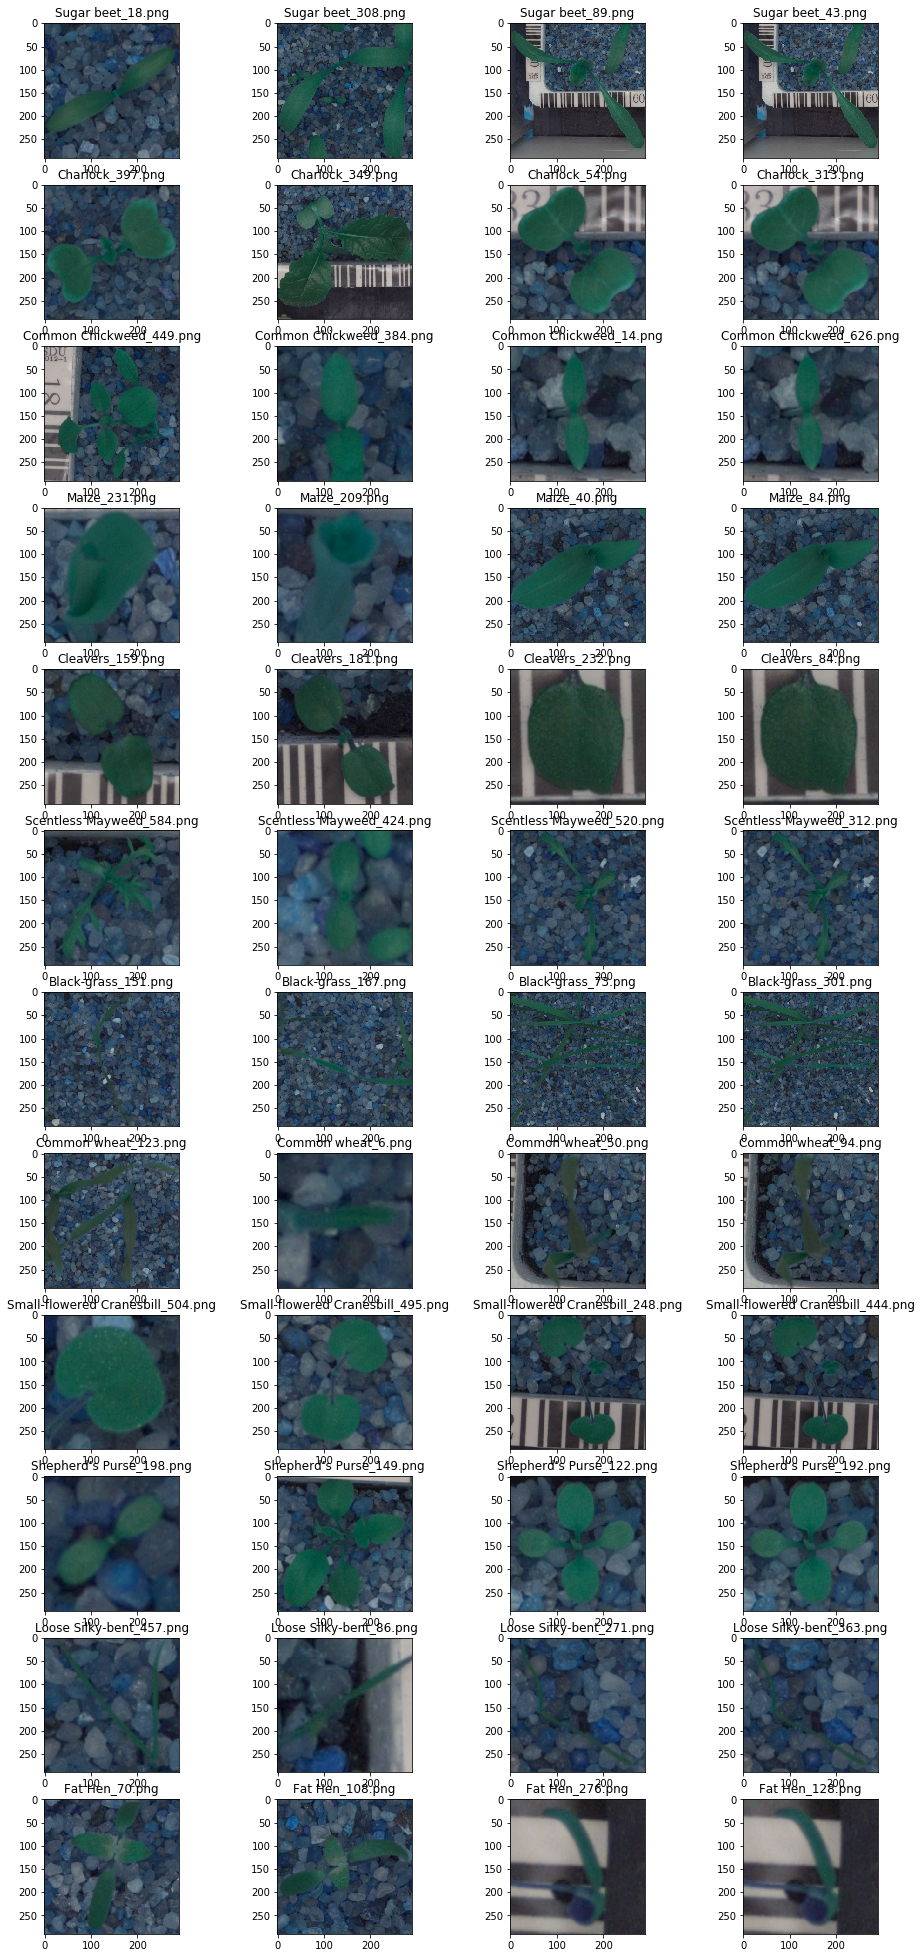

In [7]:
noOfRows = len(listDir)
plt.figure(1,figsize=(16,50))
noOfCols = 4
rowNo=0
for item in listOfClasses:
    trainItemFiles= os.listdir('./train/'+item)
    validItemFiles= os.listdir('./valid/'+item)
    for i in range(0,3):
        trainImg = cv2.imread('./train/'+item+'/'+trainItemFiles[i])
        plt.subplot(noOfRows,noOfCols,rowNo*4+i+1)
        plt.title(trainItemFiles[i])
        plt.imshow(trainImg)
    validImg = cv2.imread('./valid/'+item+'/'+validItemFiles[0])
    plt.subplot(noOfRows,noOfCols,rowNo*4+4)
    plt.imshow(trainImg)
    plt.title(validItemFiles[0])
    rowNo+=1

## 3. CNN Model Creation and Training
### 3.1 Dataset preparation 
The dataset are generated using the ImageDataGenerator() method, which is available in the Keras framework.

In [8]:
train_path = './train'
valid_path = './valid'
IMAGE_SIZE =290

num_train_samples = 225
num_val_samples = 25
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        color_mode = "rgb",
                                        classes = listOfClasses,
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        color_mode = "rgb",
                                        classes = listOfClasses,
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        color_mode = "rgb",
                                        classes = listOfClasses,
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 2700 images belonging to 12 classes.
Found 300 images belonging to 12 classes.
Found 300 images belonging to 12 classes.


### 3.2 Model Creation
The following architecture is used to create CNN model for classification.

In [9]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(12, activation = "softmax"))

model.summary()
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])
#model.save('model1.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 288, 288, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 286, 286, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 284, 284, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 142, 142, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 142, 142, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 140, 140, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 138, 138, 64)      36928     
__________

### 3.3 Model Training

In [10]:

filepath = "model1.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=50, verbose=1,
                  callbacks=callbacks_list)
model.save_weights('model1.h5')

Epoch 1/50
22/23 [===========================>..] - ETA: 3s - loss: 0.2869 - acc: 0.9167
Epoch 00001: val_acc improved from -inf to 0.91667, saving model to model1.h5
23/23 [==============================] - 78s 3s/step - loss: 0.2870 - acc: 0.9167 - val_loss: 0.2866 - val_acc: 0.9167
Epoch 2/50
22/23 [===========================>..] - ETA: 2s - loss: 0.2870 - acc: 0.9167
Epoch 00002: val_acc did not improve from 0.91667
23/23 [==============================] - 71s 3s/step - loss: 0.2870 - acc: 0.9167 - val_loss: 0.2868 - val_acc: 0.9167
Epoch 3/50
22/23 [===========================>..] - ETA: 2s - loss: 0.2869 - acc: 0.9167
Epoch 00003: val_acc did not improve from 0.91667
23/23 [==============================] - 71s 3s/step - loss: 0.2869 - acc: 0.9167 - val_loss: 0.2868 - val_acc: 0.9167
Epoch 4/50
22/23 [===========================>..] - ETA: 2s - loss: 0.2868 - acc: 0.9167
Epoch 00004: val_acc did not improve from 0.91667

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4

## 4. Results
### 4.2 Accuracy and loss

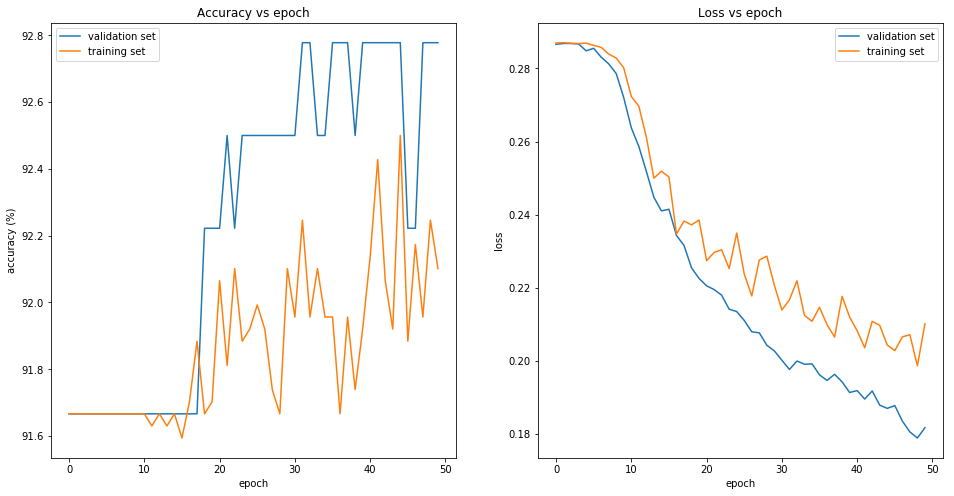

In [11]:
#

ep = range(0,len(history.history['val_acc']))
plt.figure(2,figsize=(16,8))

val_acc = history.history['val_acc']
acc =history.history['acc']
val_loss = history.history['val_loss']
loss =history.history['loss']
plt.subplot(121)
plt.plot(ep,np.multiply(val_acc,100),ep,np.multiply(acc,100))
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['validation set','training set'])
plt.title('Accuracy vs epoch')
plt.subplot(122)
plt.plot(ep,val_loss,ep,loss)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation set','training set'])
plt.title('Loss vs epoch')
plt.show()

### 4.2 Confusion Matrix

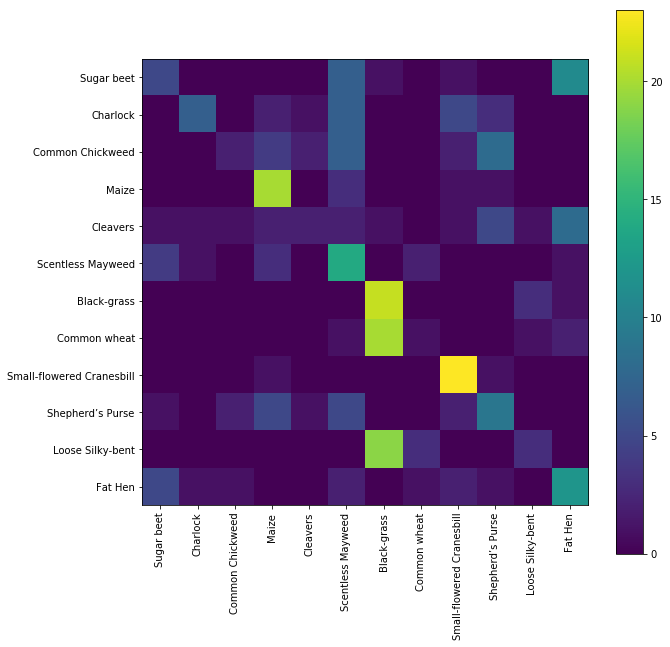

In [12]:
model.load_weights('model1.h5')
result =model.predict(test_gen)
targetLabels = np.zeros((len(test_gen),12))
for i in range(0,len(test_gen)):
     targetLabels[i]= test_gen[i][1]
#np.delete(targetLabels,[1])
y_actual = np.argmax(targetLabels,axis =1) 
y_predict = np.argmax(result,axis =1)
confMat = confusion_matrix(y_actual,y_predict)
plt.figure(3,figsize=(10,10))
plt.imshow(confMat)
plt.xticks(range(0,12),listOfClasses,rotation='vertical')
plt.yticks(range(0,12),listOfClasses)
plt.colorbar()
plt.show()

### 4.3 f1 Score

In [13]:


report= classification_report(y_actual,y_predict,target_names=listOfClasses)
print(report)

                           precision    recall  f1-score   support

               Sugar beet       0.31      0.20      0.24        25
                 Charlock       0.70      0.28      0.40        25
         Common Chickweed       0.33      0.08      0.13        25
                    Maize       0.54      0.80      0.65        25
                 Cleavers       0.33      0.08      0.13        25
        Scentless Mayweed       0.29      0.56      0.38        25
              Black-grass       0.34      0.84      0.48        25
             Common wheat       0.14      0.04      0.06        25
Small-flowered Cranesbill       0.62      0.92      0.74        25
         Shepherd’s Purse       0.32      0.36      0.34        25
         Loose Silky-bent       0.38      0.12      0.18        25
                  Fat Hen       0.34      0.48      0.40        25

                micro avg       0.40      0.40      0.40       300
                macro avg       0.39      0.40      0.34    

## Conclusion
In this notebook training of CNN network is presented for the classification of 12 different classes of plants.
## References
    1. Agricultural Center for International Agricultural Research (ACIAR) finance summary.
    2. Giselsson, T.M, Dyrmann, M., Jorgensen, R.N., Jensen, P.K & Midtiby, H.S., "A Public Image Database for Benchmark of Plant Seedling Classification Algorithms"